# Setup

In [1]:
from pycoreimage.pyci import cimg
from pycoreimage.pyci import show
from pycoreimage.pyci import color
import numpy as np
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [25,17]
from IPython.core.display import display, HTML
display(HTML("<style>.contatiner {width: 90 % !important; }</style>"))

# GPU Kernels

### Color kernel

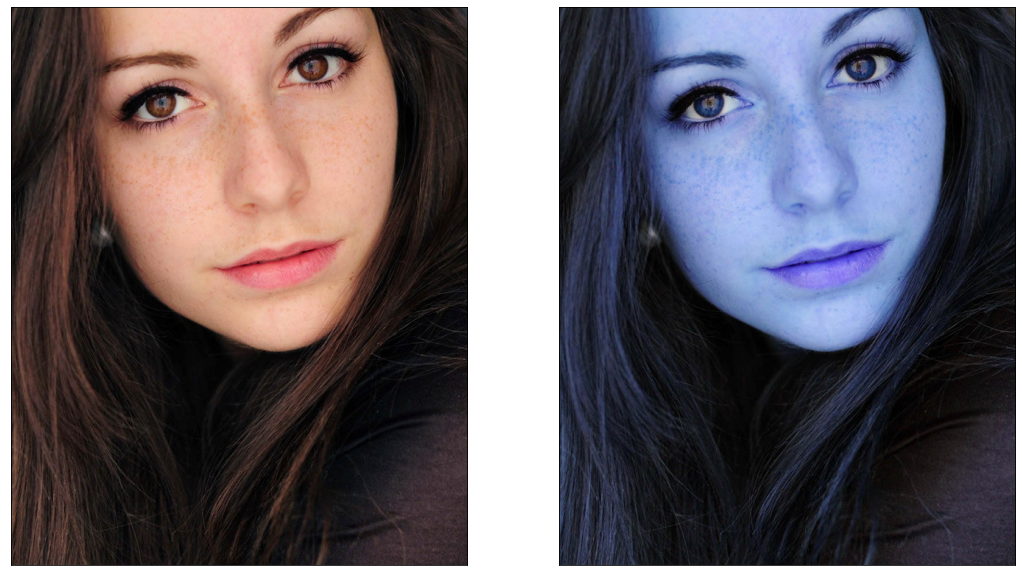

In [3]:
sampleLady = cimg.fromFile('resources/SampleImage.jpg')

source = """ kernel vec4 color(__sample img, float scale) {
    //img.r = sqrt(abs(img.r));
    //img.r = scale * img.b;
    img.rb = img.br;
    return img;
}"""
filterLady = sampleLady.applyKernel(source, 1.5)
show([sampleLady,filterLady])

### General colors

In [11]:
# make additional taps in the neighborhood of each pixel 
src = """
kernel vec4 bilateral(sampler u, float k, float colorInv, float spatialInv) {
    vec2 dc = destCoord();
    vec2 pu = samplerCoord(u);
    vec2 uDelta = samplerTransform(u, dc+vec2(1.0)) - pu;
    vec4 u_0 = sample(u, pu);
    vec4 C = vec4(0.0);
    float W = 0.0;
    for (float x = -k; x <= k; x++) {
        for (float y = -k; y <= k; y++){
            float ws = exp(-(x*x+y*y) * spatialInv);
            vec4 u_xy  = sample(u, pu + vec2(x,y)*uDelta);
            vec3 diff = u_xy.rgb-u_0.rgb;
            float wc = exp(-dot(diff,diff) * colorInv);
            W += ws * wc;
            C += ws * wc * u_xy;
        }
    }
    return W < 0.0001 ? u_0 : C / W;
}
"""
sigmaSpatial = 20
sigmaColor = 0.15
radius = 3.0 * sigmaSpatial
sampleLady1 = cimg.fromFile('resources/SampleImage.jpg')

%timeit filterLady1 = sampleLady1.applyKernel(src, 
                              radius, 
                              sigmaColor ** -2, 
                              sigmaSpatial ** -2, 
                              roi=lambda index,r: r);
show([sampleLady1,filterLady1])

IndentationError: unexpected indent (<ipython-input-11-944bb979cd75>, line 29)

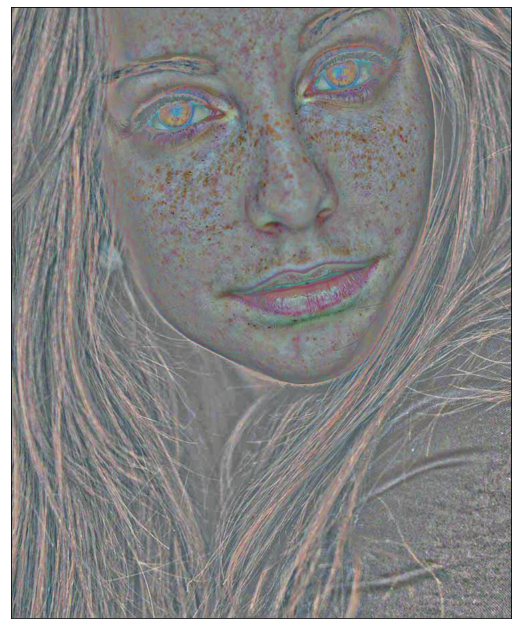

In [5]:
details = sampleLady1.render() - filterLady1.render()
detail_normal = (details - details.min()) / (details.max() - details.min())
show(detail_normal)

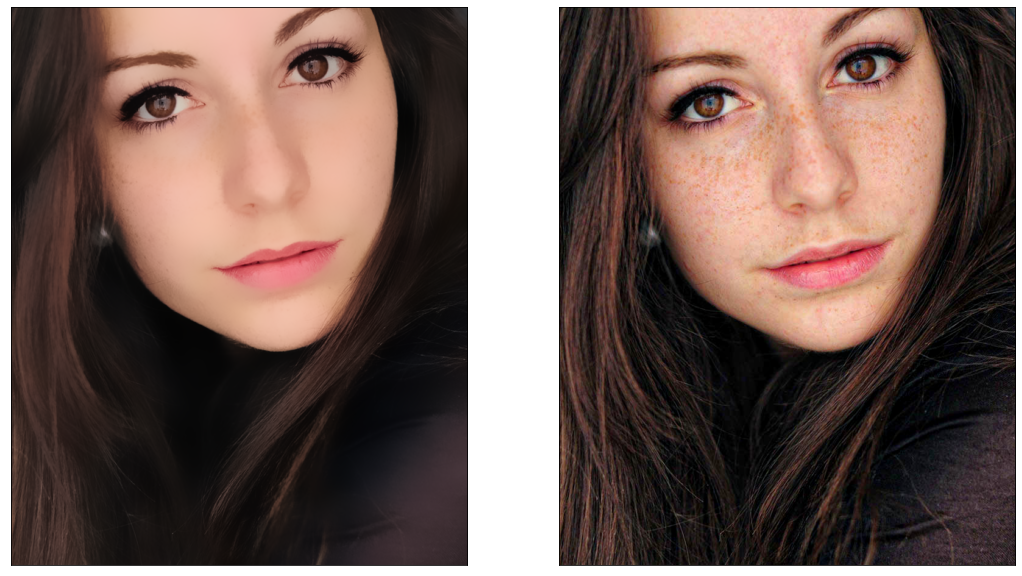

In [6]:
reduction = filterLady1.render() + 2 *  details
show([filterLady1, reduction])

### Auxiliary Images and Metadata

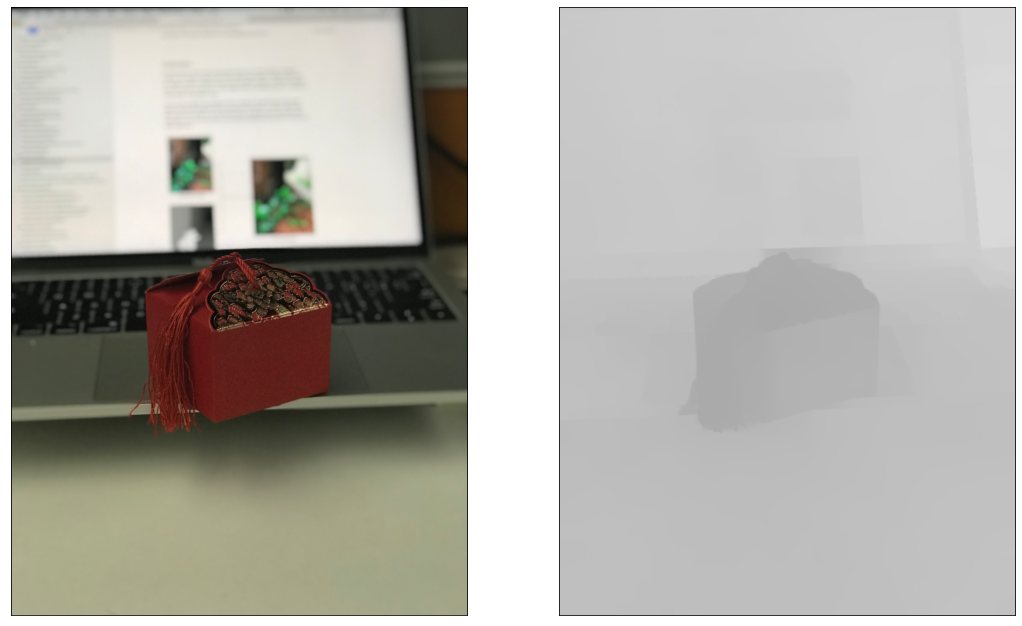

In [7]:
path = 'resources/IMG_4995.JPG'
box = cimg.fromFile(path)
# https://www.raywenderlich.com/314-image-depth-maps-tutorial-for-ios-getting-started
depth = cimg.fromFile(path, useDepth = True)
#matte = cimg.fromFile(path, useMatte = True)
show([box, depth])
#show([box, depth, matte])

In [8]:
exif = box.ciimage.properties()
#print(exif)
exif = exif['{Exif}']
#print(exif)
print('F Number', exif['FNumber'])
print('ISO', exif['ISOSpeedRatings'][0])
print('Maker', exif['LensMake'])
print('Focal length', exif['FocalLenIn35mmFilm'], 'mm')

F Number 2.8
ISO 250
Maker Apple
Focal length 57 mm
